In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import random
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegression
import random
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
tagsFile = "tags"
recipesFile = "recipes"
nutritionsFile = "nutritions"
ingredientsFile = "ingredients"

tagsdf = pd.read_csv(f"/data/foodboost/{tagsFile}.csv", index_col=0)
recipesdf = pd.read_csv(f"/data/foodboost/{recipesFile}.csv", index_col=0)

In [3]:
def recepten_bij_tag(tag):
    a = tagsdf.loc[tagsdf['tag'] == tag].recipe.to_list()
    return a
def tags_bij_recept(gerecht):
    b = tagsdf.loc[tagsdf['recipe'] == gerecht].tag.unique()
    return b

In [10]:
random.choices(tagsdf['recipe'].to_list())

['Volkorenpasta met zoete-aardappelspaghetti']

In [12]:
tagsdf.head()

,recipe,tag
0,Kruidnoten met choco-discodip,hollands
1,Kruidnoten met choco-discodip,gebak
2,Kruidnoten met choco-discodip,gebak
3,Kruidnoten met choco-discodip,sinterklaas
4,Kruidnoten met choco-discodip,sinterklaasavond


In [11]:
tags_bij_recept('Volkorenpasta met zoete-aardappelspaghetti')

array(['gezond', 'lactosevrij', 'hoofdgerecht', 'wat eten we vandaag',
       'koken', 'eiwitrijk', 'suikerbewust'], dtype=object)

In [4]:
for i in range(10):
    print(random.choices(tagsdf["tag"].to_list()))

['gebak']
['borrel']
['koken']
['stamppot']
['hoofdgerecht']
['salade']
['oven']
['kerst']
['vegetarisch']
['bakken']


In [5]:
def User_Favo_Random_Tags(randomTag = random.choices(tagsdf["tag"].to_list(), k=1), randomTagNietLekker = random.choices(tagsdf["tag"].to_list(), k=1), K=10):
    while randomTag == randomTagNietLekker:
        randomTagNietLekker = random.choices(tagsdf["tag"].to_list(), k=1)
    
    #Lekker
    RandomReceptenVoorTag = random.choices(recepten_bij_tag(randomTag[0]), k= K)
    Train_Favorieten, Test_Favorieten = RandomReceptenVoorTag[:int(K*0.8)], RandomReceptenVoorTag[int(K*0.8):]
    
    UserList_Tags = [tags_bij_recept(x) for x in Train_Favorieten]
    
    #Niet lekker
    Niet_Lekker_Recepten_Voor_Tag = random.choices(recepten_bij_tag(randomTagNietLekker[0]), k= K)
    Train_Favorieten_Niet_Lekker, Test_Favorieten_Niet_Lekker = Niet_Lekker_Recepten_Voor_Tag[:int(K*0.8)], Niet_Lekker_Recepten_Voor_Tag[int(K*0.8):]
    
    Train_Favorieten_Niet_Lekker_Tags = [tags_bij_recept(x) for x in Train_Favorieten_Niet_Lekker]
    Test_Favorieten_Niet_Lekker_Tags = [tags_bij_recept(x) for x in Test_Favorieten_Niet_Lekker]
    #RandomRecepten = random.choices(recipesdf["title"].to_list(), k=int(K*0.8))
    
    #Random_Tags = [tags_bij_recept(x) for x in RandomRecepten]


    return Train_Favorieten, UserList_Tags, Train_Favorieten_Niet_Lekker_Tags, Train_Favorieten_Niet_Lekker, randomTag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags

In [6]:
NumberOfUsers = 20
NumberOfRecipes = 20
TotalTrainMatrix = pd.DataFrame()
TotalTestMatrix = pd.DataFrame()
y_test = []

In [7]:
list_of_tags = tagsdf['tag'].unique().tolist()

In [8]:
def fillInMatrix(matrix, column, index_counter, doDoubleRows, isY, columnPrefix = "", ):
    size = len(column)
    if(type(column) == str):
        size = 1
    for i in range(size):
        matrix.loc[index_counter, columnPrefix + column[i]] = 1
        if(doDoubleRows):
            if(isY):
                matrix.loc[index_counter+1, columnPrefix + column[i]] = 0
            else:
                matrix.loc[index_counter+1, columnPrefix + column[i]] = 1

In [9]:
#TRAIN_Matrix
def generateTrainMatrix(UserList, randomTags, randomRecipes):
    
    matrix = pd.DataFrame(columns = list_of_tags)
    
    for i in range(len(UserList*2)):
        matrix.loc[matrix.shape[0]] = 0
    
    columnPrefix = "2-"
    matrix2 = matrix.copy()
    matrix2.columns = [columnPrefix + columnName for columnName in matrix2.columns]
    
    X = np.array(UserList)
    loo = LeaveOneOut()
    index_counter = 0

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]

        randomTags0 = randomTags.pop(0)
        randomgerecht0 = randomRecipes.pop(0)

        X_train_tags_unique = np.unique(np.concatenate([tags_bij_recept(x) for x in X_train]))
        X_test_tags_unique = np.unique(np.concatenate([tags_bij_recept(x) for x in X_test]))

        #----- Matrix met train vullen
        fillInMatrix(matrix, X_train_tags_unique, index_counter, True, False)
        
        #Rij 1
        fillInMatrix(matrix2, X_test_tags_unique, index_counter, False, False, columnPrefix = columnPrefix)
        #print(matrix2)
        
        #Rij 2
        fillInMatrix(matrix2, randomTags0, index_counter+1, False, False, columnPrefix = columnPrefix)
        
        #Put the value for the random tag as 1 and put y at 0, because it should be false
        fillInMatrix(matrix2, 'y', index_counter, True, True)
        
        #Show which random tag is taken and the one out
        matrix2.loc[index_counter+1, 'Randomgerecht'] = str(randomgerecht0)
        matrix2.loc[index_counter, 'one out'] = X_test
        matrix2.loc[index_counter+1, 'one out'] = X_test
        
        index_counter += 2
    return pd.concat([matrix, matrix2], axis=1)

In [10]:
#TEST_Matrix
def generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags):
    matrix1 = pd.DataFrame(columns = list_of_tags)
    Gerechten = np.array(UserList)
    Test_Gerechten = np.array(Test_Favorieten)
    
    for i in range(len(Test_Gerechten) + len(Test_Favorieten_Niet_Lekker_Tags)):
        matrix1.loc[matrix1.shape[0]] = 0
    
    matrix2 = matrix1.copy()
    columnPrefix = "2-"
    matrix2.columns = [columnPrefix + columnName for columnName in matrix2.columns]
    
    #-----
    for index_counter in range(len(Test_Gerechten)):
        
        Gerecht_Tags = np.unique(np.concatenate([tags_bij_recept(x) for x in Gerechten]))
        Test_Gerecht_Tags = tags_bij_recept(Test_Gerechten[index_counter])

        #----- Matrix1 met Userlist (1-8) invullen
        fillInMatrix(matrix1, Gerecht_Tags, index_counter, False, False)

        #----- Matrix2 met Test_Favorieten (9-10) vullen
        fillInMatrix(matrix2, Test_Gerecht_Tags, index_counter, False, False, columnPrefix = columnPrefix)
    
    for p in range(len(Test_Gerechten), len(Test_Gerechten) + len(Test_Favorieten_Niet_Lekker_Tags)):
        #----- Matrix1 met Userlist (1-8) invullen
        fillInMatrix(matrix1, Gerecht_Tags, p, False, False)
        
        fillInMatrix(matrix2, Test_Favorieten_Niet_Lekker_Tags, p, False, False, columnPrefix = columnPrefix)
    return pd.concat([matrix1, matrix2], axis=1)

In [11]:
#--Dubbele Matrix Compleet
def testTrainMatrix():
    UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User_Favo_Random_Tags(K=NumberOfRecipes)
    VolledigeMatrix = generateTrainMatrix(UserList, randomTags, randomRecipes)
    return VolledigeMatrix

In [12]:
testTrainMatrix()

,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,thais,aziatisch,curry,...,2-valentijnsdag,2-zuid-afrikaans,2-koreaans,2-kidsfavoriet,2-diner,2-lente,2-jamie oliver,y,Randomgerecht,one out
0,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Provençaalse kip met groene groenten en kriel...
1,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,Mediterrane visstoof met couscous,[Provençaalse kip met groene groenten en kriel...
2,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Pompoenmaissoep met smileys]
3,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,Gebakken kabeljauw met bloemkoolpuree,[Pompoenmaissoep met smileys]
4,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Kip met avocado-mangosalsa]
5,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,"Zalm met noedels, paksoi en sesam-limoendressing",[Kip met avocado-mangosalsa]
6,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Paksoi met oestersaus en minimais]
7,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,Gestoofde pompoen met puntpaprika en kidneybon...,[Paksoi met oestersaus en minimais]
8,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1.0,NaN,[Broodje kip met pittige boerenkool ]
9,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0.0,"Gezonde koekjes met banaan, rozijnen en kaneel",[Broodje kip met pittige boerenkool ]


In [13]:
for i in range(NumberOfUsers):
    UserList, UserList_Tags, randomTags, randomRecipes, Usertag, K, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags = User_Favo_Random_Tags(randomTag = ['hollands'], randomTagNietLekker = ['italiaans'], K=NumberOfRecipes)
    TrainMatrix = generateTrainMatrix(UserList, randomTags, randomRecipes)
    TestMatrix = generateTestMatrix(UserList, Test_Favorieten, Test_Favorieten_Niet_Lekker_Tags)
    TotalTrainMatrix = pd.concat([TotalTrainMatrix, TrainMatrix], axis=0, ignore_index=True)
    TotalTestMatrix = pd.concat([TotalTestMatrix, TestMatrix], axis=0, ignore_index=True)
    for p in Test_Favorieten:
        y_test.append(1)
    for t in Test_Favorieten_Niet_Lekker_Tags:
        y_test.append(0)

In [14]:
#--Dubbele Matrix
X_train = TotalTrainMatrix.drop(['y', 'Randomgerecht', 'one out'], axis=1)
y_train = TotalTrainMatrix['y'].to_list()

In [15]:
TotalTestMatrix_Values = TotalTestMatrix.loc[:, (TotalTestMatrix != 0).any(axis=0)]
TotalTestMatrix_Values
#TotalTestMatrix

,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,aziatisch,hoofdgerecht,koken,...,2-moederdag,2-amerikaans,2-koningsdag,2-vaderdag,2-keukenmachine,2-eiwitrijk,2-mediterraan,2-suikerbewust,2-diner,2-jamie oliver
0,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1,0,0,0,1,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
156,1,0,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
157,1,0,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
158,1,0,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
y_train

[1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0

In [17]:
AmountOfRows = X_train[X_train.columns[0]].count()
print(AmountOfRows)

640


In [18]:
def RFC():
    model_rfc = RandomForestClassifier(min_samples_split=16, min_samples_leaf=4, min_weight_fraction_leaf=0.05)
    model_rfc.fit(X_train, y_train)
    y_pred = model_rfc.predict(TotalTestMatrix)
    print(recall_score(y_test, y_pred))
    print(confusion_matrix(y_true = y_test, y_pred = y_pred))
    print(accuracy_score(y_test, y_pred))

In [19]:
RFC()

1.0
[[80  0]
 [ 0 80]]
1.0


In [20]:
def testClassifiers():
    #---Modellen
    model_lr = LogisticRegression(max_iter=AmountOfRows+100)
    model_knn = KNeighborsClassifier()
    model_svm = SVC()
    model_rfc = RandomForestClassifier()
    
    parameters_lr = {'C': np.logspace(-5, 8, 15)}
    parameters_knn = {'n_neighbors': [3, 5, 7, 9]}
    parameters_svm = {'C': [0.1, 1, 10, 100],  
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                    'gamma':['scale', 'auto'],
                    'kernel': ['linear']}
    
    #---Logistic Regression
    print("\nLogistic Regression")
    Grid_lr = GridSearchCV(model_lr, parameters_lr, cv=5)
    Grid_lr.fit(X_train, y_train)

    y_pred = Grid_lr.predict(TotalTestMatrix)

    print("y_pred: ", y_pred)
    print("Tuned Logistic Regression Parameters: {}".format(Grid_lr.best_params_)) 
    print("Best score is {}".format(Grid_lr.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
    #print("Classification Report: ", classification_report(y_test, y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Score: ", Grid_lr.score(TotalTestMatrix, y_test))

#---K_NearestNeighbors
    print("\nK_NearestNeighbors")
    Grid_knn = GridSearchCV(model_knn, parameters_knn, cv=5)
    Grid_knn.fit(X_train, y_train)

    y_pred = Grid_knn.predict(TotalTestMatrix)

    print("y_pred: ", y_pred)
    print("Tuned K_NearestNeighbors Parameters: {}".format(Grid_knn.best_params_)) 
    print("Best score is {}".format(Grid_knn.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Score: ", Grid_knn.score(TotalTestMatrix, y_test))

#---SVC
    print("\nSVM")
    Grid_svm = GridSearchCV(model_svm, parameters_svm, cv=5)
    Grid_svm.fit(X_train, y_train)

    y_pred = Grid_svm.predict(TotalTestMatrix)

    print("y_pred: ", y_pred)
    print("Tuned SVM Parameters: {}".format(Grid_svm.best_params_)) 
    print("Best score is {}".format(Grid_svm.best_score_))
    print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Score: ", Grid_svm.score(TotalTestMatrix, y_test))

    #print("Value Counts: ", pd.Series(model.predict(test_set)).value_counts())
    #print("Recall score: ", recall_score(y_test, y_pred))

    print("====================================================================")

In [21]:
#print(help(GridSearchCV))
#print(help(LogisticRegression))
#print(help(KNeighborsClassifier))
#print(help(SVC))

In [22]:
model = KNeighborsClassifier(n_neighbors = 2)

In [23]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [24]:
y_pred = model.predict(TotalTestMatrix)

In [25]:
confusion_matrix(y_true = y_test, y_pred = y_pred)

array([[80,  0],
       [ 7, 73]])

In [26]:
accuracy_score(y_test, y_pred)

0.95625

In [27]:
testClassifiers()


Logistic Regression
y_pred:  [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 1.0
Confusion Matrix:  [[80  0]
 [ 0 80]]
Accuracy Score:  1.0
Score:  1.0

K_NearestNeighbors
y_pred:  [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0.

In [28]:
#model = LogisticRegression(max_iter=AmountOfRows)

In [29]:
X_train

,hollands,gebak,sinterklaas,sinterklaasavond,oven,vooraf te maken,lactosevrij,thais,aziatisch,curry,...,2-mealprep,2-slowcooker,2-oost-europees,2-valentijnsdag,2-zuid-afrikaans,2-koreaans,2-kidsfavoriet,2-diner,2-lente,2-jamie oliver
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
638,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


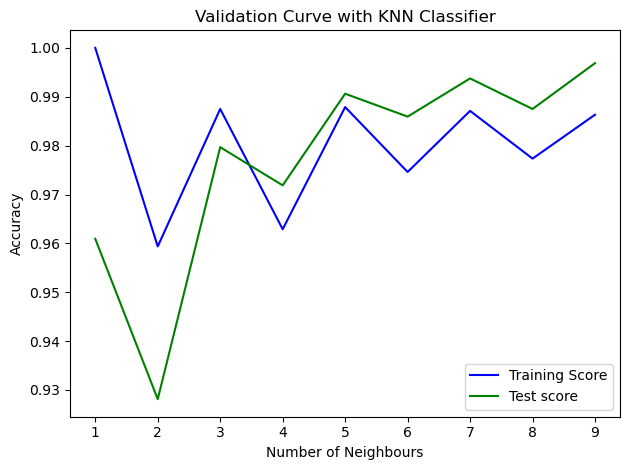

In [30]:
# Import Required libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve


# Setting the range for the parameter (from 1 to 10)
parameter_range = np.arange(1, 10, 1)

# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
									param_name = "n_neighbors",
									param_range = parameter_range,
										cv = 5, scoring = "accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
	label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
label = "Test score", color = 'g')

# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


In [31]:
#model.fit(X_train, y_train)

In [32]:
#y_pred = model.predict(TotalTestMatrix)

In [33]:
#y_pred

In [34]:
#pd.Series(model.predict(TotalTestMatrix)).value_counts()

In [35]:
#recall_score(y_test, y_pred)

In [36]:
#confusion_matrix(y_true = y_test, y_pred = y_pred)

In [37]:
#accuracy_score(y_test, y_pred)

In [38]:
# import warnings
# warnings.filterwarnings('ignore')

# #UserList, UserList_Tags, randomTags, randomRecipes, Usertag  = User_Favo_Random_Tags()
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import svm
# def Userloop(n):
#     for i in range(n):
#         print(f"\nUser{i+1}: ")
#         UserList, UserList_Tags, randomTags, randomRecipes, UserTag, K = User_Favo_Random_Tags(randomTag = random.choices(tagsdf["tag"].to_list(),
#                                                                                                 k=1), K=50)
#         matrix = generateDf(UserList, UserList_Tags, randomTags, randomRecipes, UserTag, K)
        
#         print("rangomTag: ", UserTag)
#         #print("\nTags: ", randomTags)
#         #print("\nRecipes: ", randomRecipes)
#         #print("\nFavo: ", UserList)
        
#         X = matrix.drop(['y', 'Randomgerecht', 'one out'], axis=1)
#         y = matrix['y'].to_frame()

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#     #---Modellen
#         model_lr = LogisticRegression()
#         model_knn = KNeighborsClassifier()
#         model_svm = svm.SVC()
        
#         #MOET NOG VALIDATION SPLIT AANMAKEN VOOR HET TUNEN VAN DE HYPERPARAMETERS => cv
#     #---parameters
#         parameters_lr = {'C': np.logspace(-5, 8, 15)}
#         parameters_knn = {'n_neighbors': [3, 5, 7, 9]}
#         parameters_svm = {'C': [0.1, 1, 10, 100],  
#                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#                         'gamma':['scale', 'auto'],
#                         'kernel': ['linear']}
#     #---Testset
#         #test_set = Matrix.sample(n=int(K*0.4))
    
#     #cross_val_score(estimator, X, y, scoring="*mse*, cv=n)?????
#     #.mean()
    
#     #model.best_estimator_ => beste model van alle crosvalidations (cv)
#     #---Logistic Regression
#         print("\nLogistic Regression")
#         Grid_lr = GridSearchCV(model_lr, parameters_lr, cv=5)
#         Grid_lr.fit(X_train, y_train)
        
#         y_pred = Grid_lr.predict(X_test)
        
#         print("y_pred: ", y_pred)
#         print("Tuned Logistic Regression Parameters: {}".format(Grid_lr.best_params_)) 
#         print("Best score is {}".format(Grid_lr.best_score_))
#         print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
#         #print("Classification Report: ", classification_report(y_test, y_pred))
#         print("Accuracy Score: ", accuracy_score(y_test, y_pred))
#         print("Score: ", Grid_lr.score(X_test, y_test))
        
#     #---K_NearestNeighbors
#         print("\nK_NearestNeighbors")
#         Grid_knn = GridSearchCV(model_knn, parameters_knn, cv=5)
#         Grid_knn.fit(X_train, y_train)
        
#         y_pred = Grid_knn.predict(X_test)
        
#         print("y_pred: ", y_pred)
#         print("Tuned K_NearestNeighbors Parameters: {}".format(Grid_knn.best_params_)) 
#         print("Best score is {}".format(Grid_knn.best_score_))
#         print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
#         print("Accuracy Score: ", accuracy_score(y_test, y_pred))
#         print("Score: ", Grid_knn.score(X_test, y_test))
        
#     #---SVC
#         print("\nSVM")
#         Grid_svm = GridSearchCV(model_svm, parameters_svm, cv=5)
#         Grid_svm.fit(X_train, y_train)
        
#         y_pred = Grid_svm.predict(X_test)
        
#         print("y_pred: ", y_pred)
#         print("Tuned SVM Parameters: {}".format(Grid_svm.best_params_)) 
#         print("Best score is {}".format(Grid_svm.best_score_))
#         print("Confusion Matrix: ", confusion_matrix(y_true = y_test, y_pred = y_pred))
#         print("Accuracy Score: ", accuracy_score(y_test, y_pred))
#         print("Score: ", Grid_svm.score(X_test, y_test))
        
#         #print("Value Counts: ", pd.Series(model.predict(test_set)).value_counts())
#         #print("Recall score: ", recall_score(y_test, y_pred))

#         print("====================================================================")
        

# Userloop(3)